## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install -q /content/drive/MyDrive/input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
!pip install -q /content/drive/MyDrive/input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q /content/drive/MyDrive/input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
!pip install -q /content/drive/MyDrive/input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


In [3]:
! pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
! pip install warmup_scheduler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [6]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [7]:
!pip install lion_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
# from torch.optim import Adam, SGD, AdamW
from lion_pytorch import Lion

import datetime

In [9]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [10]:
import segmentation_models_pytorch as smp

In [11]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [12]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '/content/drive/MyDrive/input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp039'#exp035(exp019+mixup0.2)+Lion optimizer

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    # backbone = 'se_resnext101_32x4d'
    backbone = 'se_resnext50_32x4d'
    #backbone = 'timm-mobilenetv3_large_100'

    in_chans = 6 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 0.33e-4 / warmup_factor

    # ============== fold =============
    valid_id = 1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'/content/drive/MyDrive/output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    os.makedirs(submission_dir, exist_ok=True)
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'
    os.makedirs(model_dir, exist_ok=True)

    figures_dir = outputs_path + 'figures/'
    os.makedirs(figures_dir, exist_ok=True)


    log_dir = outputs_path + 'logs/'
    os.makedirs(log_dir, exist_ok=True)
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [ #https://www.kaggle.com/competitions/hubmap-kidney-segmentation/discussion/238013
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.RandomRotate90(),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9,
                         border_mode=cv2.BORDER_REFLECT),
        A.OneOf([
            A.ElasticTransform(p=.3),
            A.GaussianBlur(p=.3),
            A.GaussNoise(p=.3),
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.IAAPiecewiseAffine(p=0.3),
        ], p=0.3),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3,p=0.3),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    # ============== mixup =============
    mixup = True
    if mixup:
      mixup_epoch = epochs
    else:
      mixup_epoch = 0
    mixup_alpha = 0.2


set dataset path


/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:301: FutureWarning: This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead
  warnings.warn("This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead", FutureWarning)


## helper

In [13]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [14]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [15]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [16]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [17]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------
INFO:__main__:

-------- exp_info -----------------


## image, mask

In [18]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0) #gray
        # bgr_img = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0) #BGR
        # image = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2HSV) # BGR->HSV

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0) #gray
    # bgr_mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0) #BGR
    # mask = cv2.cvtColor(bgr_mask, cv2.COLOR_BGR2HSV) # BGR->HSV 
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [19]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [20]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [21]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [22]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [23]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list,p=1.0)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list,p=1.0)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [24]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [25]:
train_dataset[0][0].shape

torch.Size([6, 224, 224])

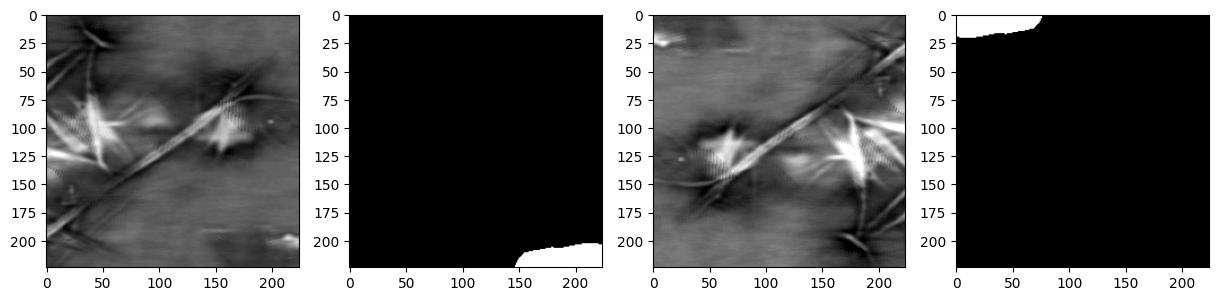

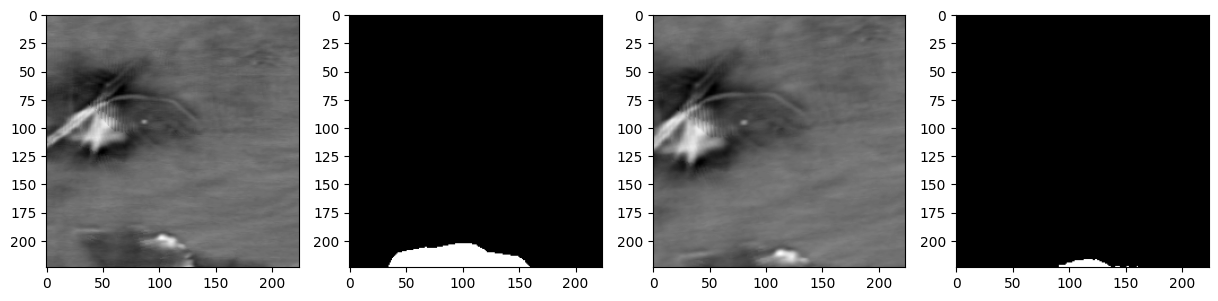

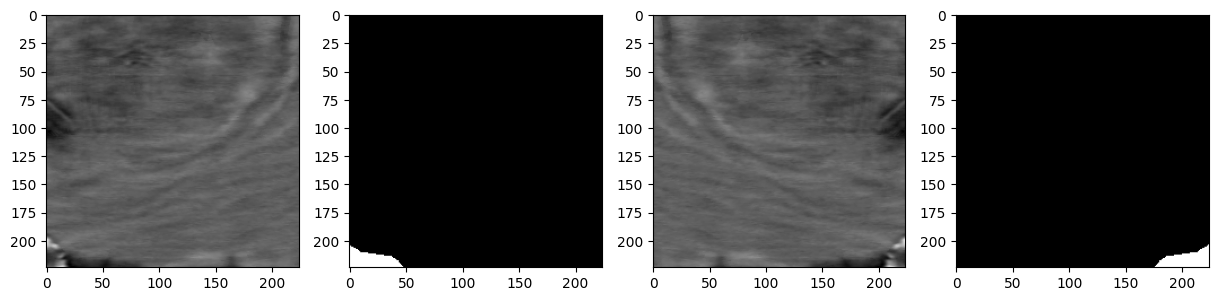

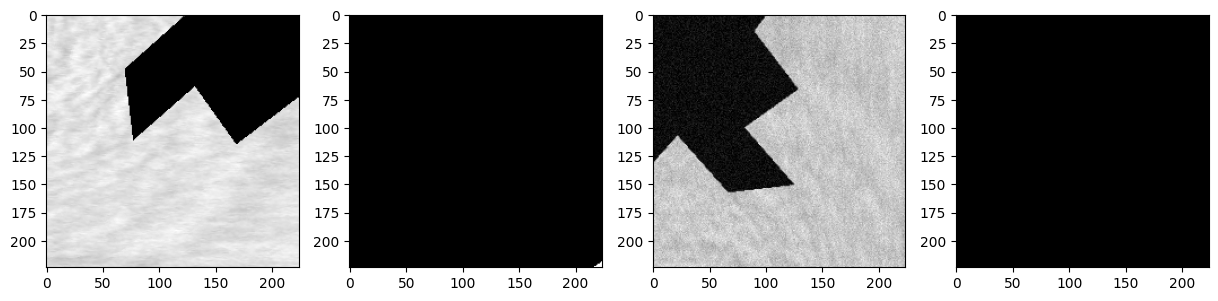

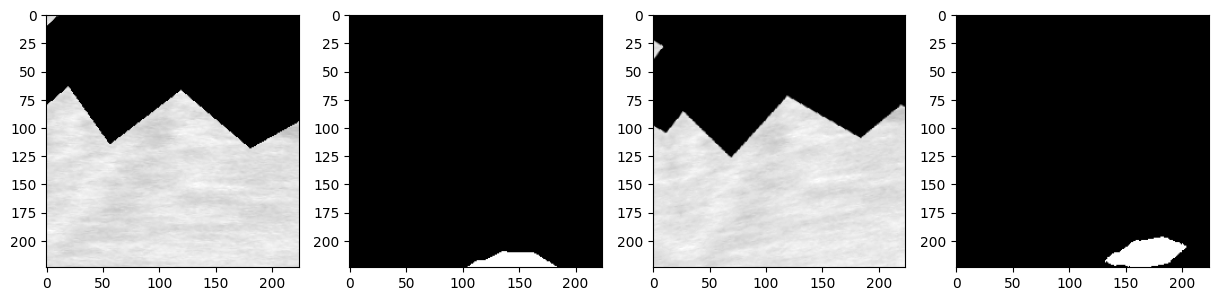

In [26]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [27]:
del plot_dataset
gc.collect()

53841

## mixup

In [28]:
def mixup_data(x, y, CFG, device):
    if CFG.mixup_alpha > 0:
        lam = np.random.beta(
            CFG.mixup_alpha, CFG.mixup_alpha
        )
    else:
        lam = 1

    batch_size = x.size()[0]
    if device == 'cuda':
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

In [29]:
def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

## model

In [30]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [31]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [32]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [33]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [34]:
model = build_model(CFG)
model.to(device)

# optimizer = AdamW(model.parameters(), lr=CFG.lr)
optimizer = Lion(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnext50_32x4d


Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/se_resnext50_32x4d-a260b3a4.pth" to /root/.cache/torch/hub/checkpoints/se_resnext50_32x4d-a260b3a4.pth
100%|██████████| 105M/105M [05:10<00:00, 356kB/s]


## loss

In [35]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [36]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        if CFG.mixup_epoch >= epoch:
          images, labels_a, labels_b, lam = mixup_data(images, labels, CFG, device)
          images = images.to(device)
          labels_a = labels_a.to(device)
          labels_b = labels_b.to(device)
        else:
          images = images.to(device)
          labels = labels.to(device)

        # images = images.to(device)
        # labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            if CFG.mixup_epoch >= epoch:
              loss = mixup_criterion(criterion, y_preds, labels_a, labels_b, lam)
            else:
              loss = criterion(y_preds, labels)
            
            # loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [37]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [38]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [39]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.12096679100688897
th: 0.15, fbeta: 0.12097508605161653
th: 0.2, fbeta: 0.12105127560188224
th: 0.25, fbeta: 0.1227917696953091
th: 0.3, fbeta: 0.2156726662782359
th: 0.35, fbeta: 0.24747688418322852
th: 0.4, fbeta: 0.2723228680631994
th: 0.45, fbeta: 0.2986327039181631


best_th: 0.5, fbeta: 0.32683186297282196
INFO:__main__:best_th: 0.5, fbeta: 0.32683186297282196
Epoch 1 - avg_train_loss: 0.6701  avg_val_loss: 0.4984  time: 588s
INFO:__main__:Epoch 1 - avg_train_loss: 0.6701  avg_val_loss: 0.4984  time: 588s
Epoch 1 - avgScore: 0.3268
INFO:__main__:Epoch 1 - avgScore: 0.3268
Epoch 1 - Save Best Score: 0.3268 Model
INFO:__main__:Epoch 1 - Save Best Score: 0.3268 Model
Epoch 1 - Save Best Loss: 0.4984 Model
INFO:__main__:Epoch 1 - Save Best Loss: 0.4984 Model


th: 0.5, fbeta: 0.32683186297282196


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.12096603095831637
th: 0.15, fbeta: 0.1209693146227934
th: 0.2, fbeta: 0.17460818957825455
th: 0.25, fbeta: 0.22481326927166806
th: 0.3, fbeta: 0.2933403478083903
th: 0.35, fbeta: 0.3378211737971124
th: 0.4, fbeta: 0.366745341343904
th: 0.45, fbeta: 0.3883216253200576


best_th: 0.5, fbeta: 0.4032244606264816
INFO:__main__:best_th: 0.5, fbeta: 0.4032244606264816
Epoch 2 - avg_train_loss: 0.4694  avg_val_loss: 0.4251  time: 605s
INFO:__main__:Epoch 2 - avg_train_loss: 0.4694  avg_val_loss: 0.4251  time: 605s
Epoch 2 - avgScore: 0.4032
INFO:__main__:Epoch 2 - avgScore: 0.4032
Epoch 2 - Save Best Score: 0.4032 Model
INFO:__main__:Epoch 2 - Save Best Score: 0.4032 Model
Epoch 2 - Save Best Loss: 0.4251 Model
INFO:__main__:Epoch 2 - Save Best Loss: 0.4251 Model


th: 0.5, fbeta: 0.4032244606264816


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


th: 0.1, fbeta: 0.2534697273171196
th: 0.15, fbeta: 0.27504954123648423
th: 0.2, fbeta: 0.301903002045784
th: 0.25, fbeta: 0.3305390437589565
th: 0.3, fbeta: 0.3548256481822133
th: 0.35, fbeta: 0.381599679941941
th: 0.4, fbeta: 0.4098806787542627
th: 0.45, fbeta: 0.4289870147822909


best_th: 0.5, fbeta: 0.46777387548242527
INFO:__main__:best_th: 0.5, fbeta: 0.46777387548242527
Epoch 3 - avg_train_loss: 0.3409  avg_val_loss: 0.2803  time: 605s
INFO:__main__:Epoch 3 - avg_train_loss: 0.3409  avg_val_loss: 0.2803  time: 605s
Epoch 3 - avgScore: 0.4678
INFO:__main__:Epoch 3 - avgScore: 0.4678
Epoch 3 - Save Best Score: 0.4678 Model
INFO:__main__:Epoch 3 - Save Best Score: 0.4678 Model
Epoch 3 - Save Best Loss: 0.2803 Model
INFO:__main__:Epoch 3 - Save Best Loss: 0.2803 Model


th: 0.5, fbeta: 0.46777387548242527


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.37353724589178405
th: 0.15, fbeta: 0.44154735360150715
th: 0.2, fbeta: 0.4813823867233
th: 0.25, fbeta: 0.5030518015497386
th: 0.3, fbeta: 0.509205467555364
th: 0.35, fbeta: 0.4965466638320779
th: 0.4, fbeta: 0.4679976119015842
th: 0.45, fbeta: 0.42405848298854104


best_th: 0.3, fbeta: 0.509205467555364
INFO:__main__:best_th: 0.3, fbeta: 0.509205467555364
Epoch 4 - avg_train_loss: 0.2805  avg_val_loss: 0.2283  time: 598s
INFO:__main__:Epoch 4 - avg_train_loss: 0.2805  avg_val_loss: 0.2283  time: 598s
Epoch 4 - avgScore: 0.5092
INFO:__main__:Epoch 4 - avgScore: 0.5092
Epoch 4 - Save Best Score: 0.5092 Model
INFO:__main__:Epoch 4 - Save Best Score: 0.5092 Model
Epoch 4 - Save Best Loss: 0.2283 Model
INFO:__main__:Epoch 4 - Save Best Loss: 0.2283 Model


th: 0.5, fbeta: 0.35016471319262643


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2937836387168256
th: 0.15, fbeta: 0.33047031475190547
th: 0.2, fbeta: 0.3604438427557046
th: 0.25, fbeta: 0.3925724585588888
th: 0.3, fbeta: 0.429874600111709
th: 0.35, fbeta: 0.47095373256145
th: 0.4, fbeta: 0.49365104403389276
th: 0.45, fbeta: 0.5016149577904033


best_th: 0.45, fbeta: 0.5016149577904033
INFO:__main__:best_th: 0.45, fbeta: 0.5016149577904033
Epoch 5 - avg_train_loss: 0.2719  avg_val_loss: 0.2270  time: 594s
INFO:__main__:Epoch 5 - avg_train_loss: 0.2719  avg_val_loss: 0.2270  time: 594s
Epoch 5 - avgScore: 0.5016
INFO:__main__:Epoch 5 - avgScore: 0.5016


th: 0.5, fbeta: 0.4891643265982099


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3476204254727557
th: 0.15, fbeta: 0.38772093319804174
th: 0.2, fbeta: 0.42341429877488945
th: 0.25, fbeta: 0.4601279019524327
th: 0.3, fbeta: 0.4949327160704853
th: 0.35, fbeta: 0.5063451911254521
th: 0.4, fbeta: 0.503988181037961
th: 0.45, fbeta: 0.4904792649203116


best_th: 0.35, fbeta: 0.5063451911254521
INFO:__main__:best_th: 0.35, fbeta: 0.5063451911254521
Epoch 6 - avg_train_loss: 0.2621  avg_val_loss: 0.2293  time: 701s
INFO:__main__:Epoch 6 - avg_train_loss: 0.2621  avg_val_loss: 0.2293  time: 701s
Epoch 6 - avgScore: 0.5063
INFO:__main__:Epoch 6 - avgScore: 0.5063


th: 0.5, fbeta: 0.46257758407739086


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3179517434415687
th: 0.15, fbeta: 0.3530068002737492
th: 0.2, fbeta: 0.3816789761870674
th: 0.25, fbeta: 0.40510380024457
th: 0.3, fbeta: 0.4266576130894181
th: 0.35, fbeta: 0.44531081763852676
th: 0.4, fbeta: 0.4665160543087331
th: 0.45, fbeta: 0.4897384950900333


best_th: 0.5, fbeta: 0.5068296584485025
INFO:__main__:best_th: 0.5, fbeta: 0.5068296584485025
Epoch 7 - avg_train_loss: 0.2569  avg_val_loss: 0.2317  time: 708s
INFO:__main__:Epoch 7 - avg_train_loss: 0.2569  avg_val_loss: 0.2317  time: 708s
Epoch 7 - avgScore: 0.5068
INFO:__main__:Epoch 7 - avgScore: 0.5068


th: 0.5, fbeta: 0.5068296584485025


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3539025047573778
th: 0.15, fbeta: 0.39233801688045244
th: 0.2, fbeta: 0.42858636046102555
th: 0.25, fbeta: 0.46375386775070015
th: 0.3, fbeta: 0.4932484760028721
th: 0.35, fbeta: 0.5181038012059908
th: 0.4, fbeta: 0.5367182664689385
th: 0.45, fbeta: 0.5445302399184953


best_th: 0.45, fbeta: 0.5445302399184953
INFO:__main__:best_th: 0.45, fbeta: 0.5445302399184953
Epoch 8 - avg_train_loss: 0.2494  avg_val_loss: 0.2267  time: 706s
INFO:__main__:Epoch 8 - avg_train_loss: 0.2494  avg_val_loss: 0.2267  time: 706s
Epoch 8 - avgScore: 0.5445
INFO:__main__:Epoch 8 - avgScore: 0.5445
Epoch 8 - Save Best Score: 0.5445 Model
INFO:__main__:Epoch 8 - Save Best Score: 0.5445 Model
Epoch 8 - Save Best Loss: 0.2267 Model
INFO:__main__:Epoch 8 - Save Best Loss: 0.2267 Model


th: 0.5, fbeta: 0.542185314724212


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.37010542998912793
th: 0.15, fbeta: 0.4130083730988596
th: 0.2, fbeta: 0.44630115549466065
th: 0.25, fbeta: 0.4726667026455622
th: 0.3, fbeta: 0.49668051899489113
th: 0.35, fbeta: 0.5173725476002781
th: 0.4, fbeta: 0.5301545082150285
th: 0.45, fbeta: 0.534217360375522


best_th: 0.45, fbeta: 0.534217360375522
INFO:__main__:best_th: 0.45, fbeta: 0.534217360375522
Epoch 9 - avg_train_loss: 0.2433  avg_val_loss: 0.2223  time: 687s
INFO:__main__:Epoch 9 - avg_train_loss: 0.2433  avg_val_loss: 0.2223  time: 687s
Epoch 9 - avgScore: 0.5342
INFO:__main__:Epoch 9 - avgScore: 0.5342


th: 0.5, fbeta: 0.5320812445285447


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.38224241356962047
th: 0.15, fbeta: 0.4137384601988723
th: 0.2, fbeta: 0.43591964802218963
th: 0.25, fbeta: 0.4536441494990918
th: 0.3, fbeta: 0.4656087290720295
th: 0.35, fbeta: 0.4763671178093295
th: 0.4, fbeta: 0.48122118879208997
th: 0.45, fbeta: 0.47661504712769637


best_th: 0.4, fbeta: 0.48122118879208997
INFO:__main__:best_th: 0.4, fbeta: 0.48122118879208997
Epoch 10 - avg_train_loss: 0.2352  avg_val_loss: 0.2520  time: 671s
INFO:__main__:Epoch 10 - avg_train_loss: 0.2352  avg_val_loss: 0.2520  time: 671s
Epoch 10 - avgScore: 0.4812
INFO:__main__:Epoch 10 - avgScore: 0.4812


th: 0.5, fbeta: 0.47011530757723263


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.371426992574857
th: 0.15, fbeta: 0.40800718011660303
th: 0.2, fbeta: 0.44217460749715454
th: 0.25, fbeta: 0.473735594410797
th: 0.3, fbeta: 0.49243271335788846
th: 0.35, fbeta: 0.5048796062948068
th: 0.4, fbeta: 0.5179754707099402
th: 0.45, fbeta: 0.5238480353057045


best_th: 0.45, fbeta: 0.5238480353057045
INFO:__main__:best_th: 0.45, fbeta: 0.5238480353057045
Epoch 11 - avg_train_loss: 0.2302  avg_val_loss: 0.2335  time: 680s
INFO:__main__:Epoch 11 - avg_train_loss: 0.2302  avg_val_loss: 0.2335  time: 680s
Epoch 11 - avgScore: 0.5238
INFO:__main__:Epoch 11 - avgScore: 0.5238


th: 0.5, fbeta: 0.5221578500198858


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.35933928939575893
th: 0.15, fbeta: 0.3948991373409755
th: 0.2, fbeta: 0.42068312448759076
th: 0.25, fbeta: 0.44261465165762026
th: 0.3, fbeta: 0.46091653364076063
th: 0.35, fbeta: 0.476880886524128
th: 0.4, fbeta: 0.4894090420638278
th: 0.45, fbeta: 0.49897675726826873


best_th: 0.5, fbeta: 0.50438168549017
INFO:__main__:best_th: 0.5, fbeta: 0.50438168549017
Epoch 12 - avg_train_loss: 0.2247  avg_val_loss: 0.2340  time: 718s
INFO:__main__:Epoch 12 - avg_train_loss: 0.2247  avg_val_loss: 0.2340  time: 718s
Epoch 12 - avgScore: 0.5044
INFO:__main__:Epoch 12 - avgScore: 0.5044


th: 0.5, fbeta: 0.50438168549017


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.37552713826240186
th: 0.15, fbeta: 0.4057582643894612
th: 0.2, fbeta: 0.4359816094614409
th: 0.25, fbeta: 0.46604853251963263
th: 0.3, fbeta: 0.4951885362813703
th: 0.35, fbeta: 0.5195323853666245
th: 0.4, fbeta: 0.5383857307377871
th: 0.45, fbeta: 0.5548519460438158


best_th: 0.5, fbeta: 0.5553639899049263
INFO:__main__:best_th: 0.5, fbeta: 0.5553639899049263
Epoch 13 - avg_train_loss: 0.2181  avg_val_loss: 0.2280  time: 735s
INFO:__main__:Epoch 13 - avg_train_loss: 0.2181  avg_val_loss: 0.2280  time: 735s
Epoch 13 - avgScore: 0.5554
INFO:__main__:Epoch 13 - avgScore: 0.5554
Epoch 13 - Save Best Score: 0.5554 Model
INFO:__main__:Epoch 13 - Save Best Score: 0.5554 Model
Epoch 13 - Save Best Loss: 0.2280 Model
INFO:__main__:Epoch 13 - Save Best Loss: 0.2280 Model


th: 0.5, fbeta: 0.5553639899049263


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.36308979417194204
th: 0.15, fbeta: 0.40101896348739596
th: 0.2, fbeta: 0.43730278695234864
th: 0.25, fbeta: 0.46440277841765243
th: 0.3, fbeta: 0.4865934880307782
th: 0.35, fbeta: 0.5084307774589905
th: 0.4, fbeta: 0.5319611938518197
th: 0.45, fbeta: 0.5521059155578752


best_th: 0.5, fbeta: 0.5645804797124294
INFO:__main__:best_th: 0.5, fbeta: 0.5645804797124294
Epoch 14 - avg_train_loss: 0.2125  avg_val_loss: 0.2238  time: 670s
INFO:__main__:Epoch 14 - avg_train_loss: 0.2125  avg_val_loss: 0.2238  time: 670s
Epoch 14 - avgScore: 0.5646
INFO:__main__:Epoch 14 - avgScore: 0.5646
Epoch 14 - Save Best Score: 0.5646 Model
INFO:__main__:Epoch 14 - Save Best Score: 0.5646 Model
Epoch 14 - Save Best Loss: 0.2238 Model
INFO:__main__:Epoch 14 - Save Best Loss: 0.2238 Model


th: 0.5, fbeta: 0.5645804797124294


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.36722531109715073
th: 0.15, fbeta: 0.409431257254886
th: 0.2, fbeta: 0.443016533905718
th: 0.25, fbeta: 0.4725577269586973
th: 0.3, fbeta: 0.49958559341980413
th: 0.35, fbeta: 0.5269124834036151
th: 0.4, fbeta: 0.5484901518127323
th: 0.45, fbeta: 0.56532991682661


best_th: 0.5, fbeta: 0.5788744878185019
INFO:__main__:best_th: 0.5, fbeta: 0.5788744878185019
Epoch 15 - avg_train_loss: 0.2103  avg_val_loss: 0.2194  time: 708s
INFO:__main__:Epoch 15 - avg_train_loss: 0.2103  avg_val_loss: 0.2194  time: 708s
Epoch 15 - avgScore: 0.5789
INFO:__main__:Epoch 15 - avgScore: 0.5789
Epoch 15 - Save Best Score: 0.5789 Model
INFO:__main__:Epoch 15 - Save Best Score: 0.5789 Model
Epoch 15 - Save Best Loss: 0.2194 Model
INFO:__main__:Epoch 15 - Save Best Loss: 0.2194 Model


th: 0.5, fbeta: 0.5788744878185019


In [40]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [41]:
mask_pred = check_point['preds']

In [42]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.36722531109715073
th: 0.15, fbeta: 0.409431257254886
th: 0.2, fbeta: 0.443016533905718
th: 0.25, fbeta: 0.4725577269586973
th: 0.3, fbeta: 0.49958559341980413
th: 0.35, fbeta: 0.5269124834036151
th: 0.4, fbeta: 0.5484901518127323
th: 0.45, fbeta: 0.56532991682661


best_th: 0.5, fbeta: 0.5788744878185019
INFO:__main__:best_th: 0.5, fbeta: 0.5788744878185019


th: 0.5, fbeta: 0.5788744878185019


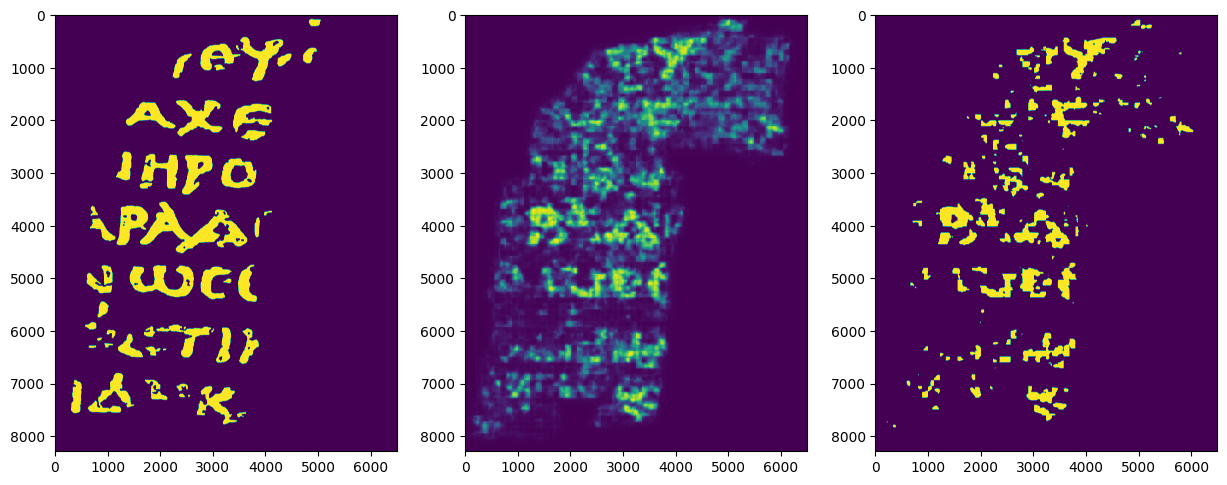

In [43]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([34840059.,  5113671.,  2839847.,  1868044.,  1414947.,  1198919.,
          978276.,   800313.,   662588.,   574424.,   507949.,   472700.,
          456366.,   433365.,   446619.,   406770.,   360246.,   270158.,
          155294.,    38293.]),
 array([9.00469604e-05, 4.76719082e-02, 9.52537694e-02, 1.42835631e-01,
        1.90417492e-01, 2.37999353e-01, 2.85581214e-01, 3.33163075e-01,
        3.80744937e-01, 4.28326798e-01, 4.75908659e-01, 5.23490520e-01,
        5.71072381e-01, 6.18654243e-01, 6.66236104e-01, 7.13817965e-01,
        7.61399826e-01, 8.08981687e-01, 8.56563549e-01, 9.04145410e-01,
        9.51727271e-01]),
 <BarContainer object of 20 artists>)

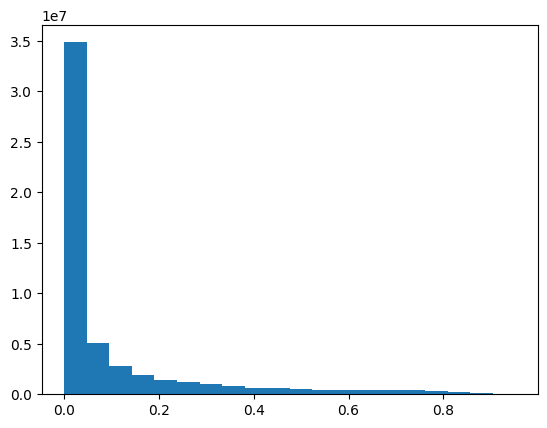

In [44]:
plt.hist(mask_pred.flatten(), bins=20)